<a href="https://colab.research.google.com/github/rajiv-ranjan/cds-mini-projects/blob/Archana/M3_NB_MiniProject_2_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1259 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people do not correctly wear their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset:

- Without Mask/ With Mask/ Partial Mask

Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

## Grading = 10 Points

In [1]:
# @title Download the data
# !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
# !unzip -qq MP2_FaceMask_Dataset.zip
# print("Data Downloaded Successfuly!!")


from utility import download_and_unzip

download_and_unzip(
    filename="MP2_FaceMask_Dataset.zip",
    url="https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip",
)


--2025-03-09 09:24:02--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 589920212 (563M) [application/zip]
Saving to: ‘MP2_FaceMask_Dataset.zip’

     0K .......... .......... .......... .......... ..........  0% 1.96M 4m47s
    50K .......... .......... .......... .......... ..........  0% 1.84M 4m56s
   100K .......... .......... .......... .......... ..........  0% 25.8M 3m25s
   150K .......... .......... .......... .......... ..........  0% 1.14M 4m36s
   200K .......... .......... .......... .......... ..........  0% 14.0M 3m49s
   250K .......... .......... .......... .......... ..........  0% 61.0M 3m12s
   300K .......... .......... .......... .......... ..........  0% 22.1M 2m49s
   350K .......... .......... ...

True

### Import Required packages

In [10]:
from tensorflow.keras.optimizers import RMSprop

# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (
    Conv2D,
    Input,
    ZeroPadding2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow import keras
import glob, os


## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

In [11]:
# analyze the shape of images


def load_images(img_path):
    shapes = []
    labels = []
    for label in os.listdir(img_path):
        for img in os.listdir(os.path.join(img_path, label)):
            img = PIL.Image.open(os.path.join(img_path, label, img))
            shapes.append(img.size)
            labels.append(label)

    shapes = np.unique(shapes, axis=0)
    labels = np.unique(labels, axis=0)
    return shapes, labels


# img_path = "/content/MP2_FaceMask_Dataset/train/"
img_path = "MP2_FaceMask_Dataset/train/"
shapes, labels = load_images(img_path)

print(f"Number of different image shapes :  {np.size(shapes)}")
print(f"Labels : {labels}")


Number of different image shapes :  656
Labels : ['partial_mask' 'with_mask' 'without_mask']


### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [12]:
# TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
# VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

TRAINING_DIR = "MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "MP2_FaceMask_Dataset/test/"


In [13]:
# YOUR CODE HERE
# Instantiate ImageDataGenerator
gen = ImageDataGenerator(
    rescale=1.0 / 255,
    width_shift_range=0.005,
    height_shift_range=0.005,
    rotation_range=0,
    horizontal_flip=True,
)


In [14]:
# Generate batches of tensor image data
train_batches = gen.flow_from_directory(
    TRAINING_DIR, target_size=(224, 224), batch_size=32, class_mode="categorical"
)
val_batches = gen.flow_from_directory(
    VALIDATION_DIR, target_size=(224, 224), batch_size=32, class_mode="categorical"
)


Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


### Visualize the sample images of each class using data generator

Hint: plt.subplot

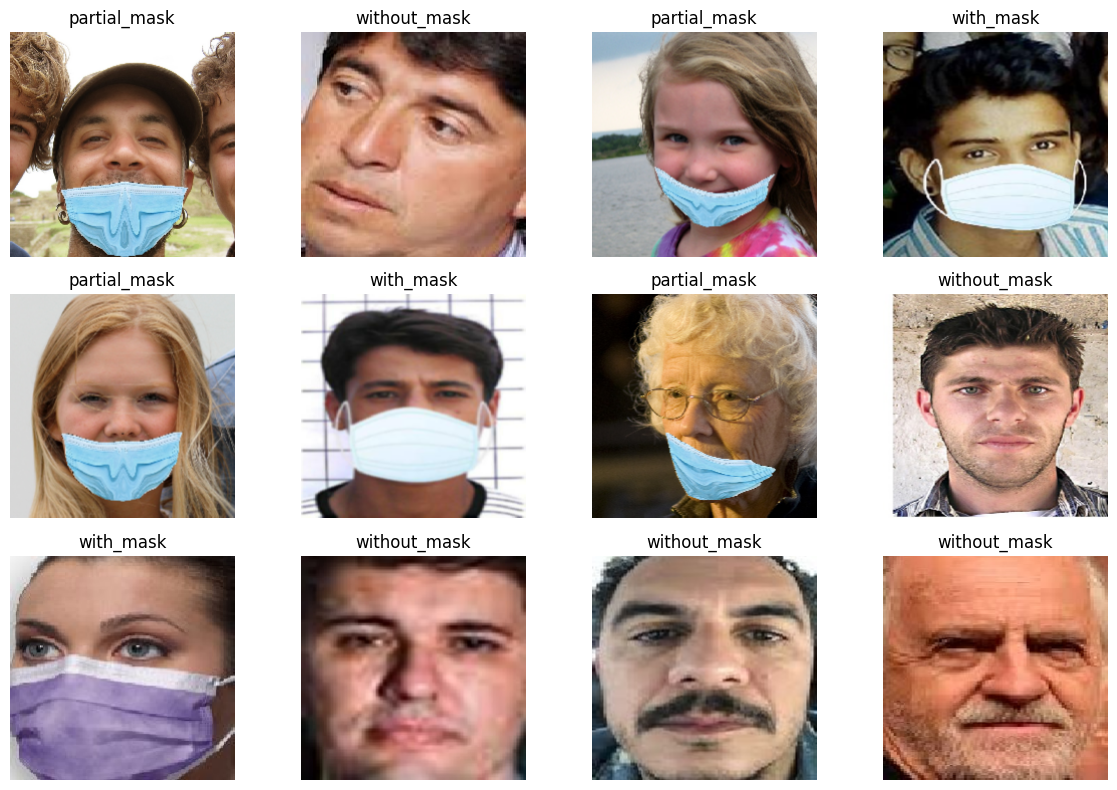

In [15]:
# function to plot images
def plot_sample_images(images, labels, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])  # Convert one-hot encoding to class index
        plt.title(class_names[label_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


images, labels = next(train_batches)  # Get the first batch of images and labels
class_names = list(train_batches.class_indices.keys())

plot_sample_images(images, labels, class_names)


## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [16]:
# Initialize the CNN
model = Sequential(
    [
        Conv2D(
            32, (3, 3), activation="relu", padding="same", input_shape=[224, 224, 3]
        ),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)


/Users/rajiv-ranjan/Documents/github/rajiv-ranjan/cds-mini-projects/m3/archana-mp3/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# compile model with optimizer and loss function

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,946,883 (49.39 MB)

 Trainable params: 12,946,883 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# train the model


train_model = model.fit(
    train_batches, epochs=20, verbose=2, validation_data=val_batches
)


/Users/rajiv-ranjan/Documents/github/rajiv-ranjan/cds-mini-projects/m3/archana-mp3/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
158/158 - 87s - 550ms/step - accuracy: 0.8014 - loss: 0.5168 - val_accuracy: 0.9285 - val_loss: 0.1957
Epoch 2/20
158/158 - 80s - 507ms/step - accuracy: 0.9191 - loss: 0.2620 - val_accuracy: 0.9309 - val_loss: 0.2305
Epoch 3/20
158/158 - 83s - 523ms/step - accuracy: 0.9455 - loss: 0.1856 - val_accuracy: 0.9587 - val_loss: 0.1314
Epoch 4/20
158/158 - 84s - 529ms/step - accuracy: 0.9576 - loss: 0.1361 - val_accuracy: 0.9619 - val_loss: 0.1578
Epoch 5/20
158/158 - 81s - 510ms/step - accuracy: 0.9640 - loss: 0.1281 - val_accuracy: 0.9714 - val_loss: 0.1126
Epoch 6/20
158/158 - 81s - 512ms/step - accuracy: 0.9604 - loss: 0.1349 - val_accuracy: 0.9754 - val_loss: 0.0938
Epoch 7/20
158/158 - 87s - 547ms/step - accuracy: 0.9670 - loss: 0.1134 - val_accuracy: 0.9722 - val_loss: 0.1023
Epoch 8/20
158/158 - 86s - 547ms/step - accuracy: 0.9710 - loss: 0.0943 - val_accuracy: 0.9698 - val_loss: 0.1184
Epoch 9/20
158/158 - 79s - 502ms/step - accuracy: 0.9692 - loss: 0.1112 - val_accuracy: 

In [19]:
# model evaluation on validation data
val_loss, val_accuracy = model.evaluate(val_batches)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9744 - loss: 0.0988
Validation loss: 0.09466572850942612
Validation accuracy: 0.9753772616386414


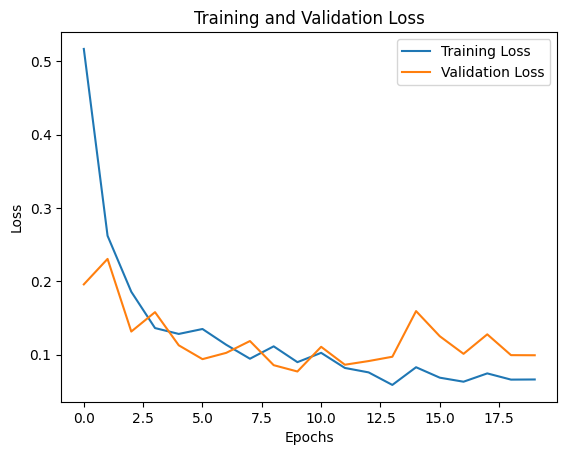

In [20]:
# Plot training and validation loss
plt.plot(train_model.history["loss"], label="Training Loss")
plt.plot(train_model.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_VGG16.pdf) or [ResNet50](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_ResNet50.pdf))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/how-to-use-a-pre-trained-model-vgg-for-image-classification-8dd7c4a4a517/)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

#### VGG16

In [21]:
# Create a custom image classification model using VGG16 as the base with added Dense layers for fine-tuning in TensorFlow Keras.
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [22]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)  # Custom dense layer
x = Dropout(0.5)(x)  # Regularization
x = Dense(128, activation="relu")(x)  # Another custom dense layer
x = Dropout(0.5)(x)

# Output layer for classification
output = Dense(3, activation="softmax")(x)  # Change 3 to the number of your classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)


In [23]:
import tensorflow as tf

# Compile the VGG16-based model with the Adam optimizer (learning rate 0.00001), categorical cross-entropy loss, and accuracy as the metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           38

 Total params: 21,170,755 (80.76 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [24]:
# Train the VGG16-based model for 5 epochs using the training and validation data generators, with specified class weights {0:1.0, 1:0.8, 2:1.2}
train_model = model.fit(
    train_batches,
    epochs=5,
    verbose=2,
    validation_data=val_batches,
    class_weight={0: 1.0, 1: 0.8, 2: 1.2},
)

# YOUR CODE HERE


Epoch 1/5
158/158 - 430s - 3s/step - accuracy: 0.6130 - loss: 0.8182 - val_accuracy: 0.9237 - val_loss: 0.3709
Epoch 2/5
158/158 - 407s - 3s/step - accuracy: 0.8365 - loss: 0.4292 - val_accuracy: 0.9508 - val_loss: 0.1959
Epoch 3/5
158/158 - 408s - 3s/step - accuracy: 0.9032 - loss: 0.2797 - val_accuracy: 0.9666 - val_loss: 0.1298
Epoch 4/5
158/158 - 419s - 3s/step - accuracy: 0.9215 - loss: 0.2202 - val_accuracy: 0.9643 - val_loss: 0.1067
Epoch 5/5
158/158 - 432s - 3s/step - accuracy: 0.9376 - loss: 0.1840 - val_accuracy: 0.9754 - val_loss: 0.0848


In [25]:
# model evaluation on validation data
val_loss, val_accuracy = model.evaluate(val_batches)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9736 - loss: 0.0839
Validation loss: 0.08392861485481262
Validation accuracy: 0.9753772616386414


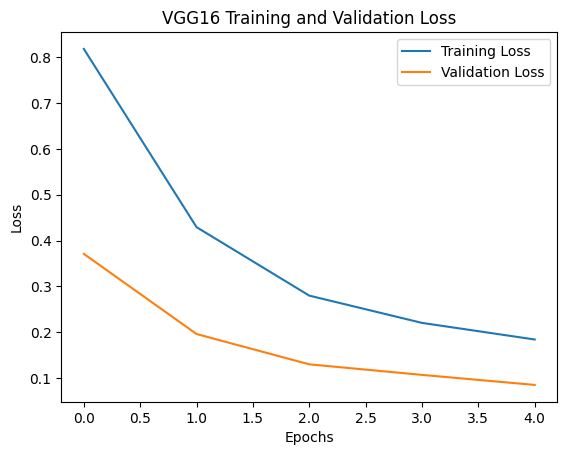

In [26]:
# Plot the training and validation loss over epochs
plt.plot(train_model.history["loss"], label="Training Loss")
plt.plot(train_model.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VGG16 Training and Validation Loss")
plt.show()


In [27]:
# Save the model in HDF5 format
model.save("model_vgg.h5")


In [28]:
# Save the model in keras format
model.save("model_vgg.keras")


#### ResNet50

In [29]:
# Build and compile a sequential model using ResNet50 as the base, with added Dense layers for classification, and display the model summary

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the ResNet50 base model
model.add(base_model)

# Flatten the output of the ResNet50 base model
model.add(Flatten())

# Add fully connected layers for classification
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax"))  # Final layer for classification (10 classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Display the model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,311,363 (188.11 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
# Train the ResNet50-based model for 5 epochs using the training and validation data generators
train_model = model.fit(
    train_batches,
    epochs=5,
    verbose=2,
    validation_data=val_batches,
    class_weight={0: 1.0, 1: 0.8, 2: 1.2},
)


Epoch 1/5
158/158 - 153s - 971ms/step - accuracy: 0.3852 - loss: 1.1716 - val_accuracy: 0.4241 - val_loss: 1.0578
Epoch 2/5
158/158 - 140s - 887ms/step - accuracy: 0.4068 - loss: 1.0173 - val_accuracy: 0.4241 - val_loss: 0.9526
Epoch 3/5
158/158 - 142s - 900ms/step - accuracy: 0.4176 - loss: 0.9768 - val_accuracy: 0.4241 - val_loss: 0.9444
Epoch 4/5
158/158 - 143s - 905ms/step - accuracy: 0.4208 - loss: 0.9456 - val_accuracy: 0.4241 - val_loss: 0.8791
Epoch 5/5
158/158 - 144s - 909ms/step - accuracy: 0.4225 - loss: 0.9236 - val_accuracy: 0.4241 - val_loss: 0.8640


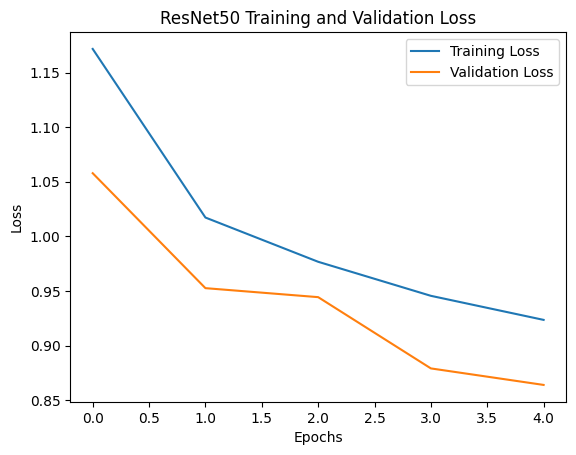

In [31]:
# Plot the training and validation loss over epochs
plt.plot(train_model.history["loss"], label="Training Loss")
plt.plot(train_model.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet50 Training and Validation Loss")
plt.show()


### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))


<IPython.core.display.Javascript object>

NotAllowedError: Permission denied


After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which the model accepts.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
MODEL = model_vgg
features = PIL.Image.open("photo.jpg")
features = features.resize((224, 224))
plt.imshow(features);
# YOUR CODE HERE to predict the image


### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- What process was followed to tune the hyperparameters?
- Discuss the confusion matrix in terms of the misclassifications

### Kaggle predictions

In [ ]:
# Download the saved VGG model
# Your code here


### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1eB26tqAXrP3z1WTjSEbOnaSqAOqdWJ7O/view?usp=drive_link)

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).
  - Note that at the time of submission to Kaggle, predictions need to be sorted in ascending order i.e, same as sample submission file.

<font color='magenta'>If you are unable to download the data and sample submission from the Kaggle Competition site then please use the download cell below.</font>


In [ ]:
#@title Download test data and SampleSubmission file for Kaggle submission
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/FaceMask_Kaggle_test.zip
!unzip -qq FaceMask_Kaggle_test.zip
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/Sample_Submission.csv
print("Data Downloaded Successfuly!!")


#### Create a dataframe with kaggle data

In [ ]:
# Create a DataFrame of image paths from the "FaceMask_Kaggle_test" directory, extract and sort by the numeric order in the filenames, and display the DataFrame
# YOUR CODE HERE


In [ ]:
# Display rows 120 to 135 of the DataFrame
# YOUR CODE HERE


#### Extract features of kaggle data

In [ ]:
# Resize images from the img_path column in the DataFrame df to 224x224, append them to a list, and convert the list to a NumPy array
# YOUR CODE HERE


#### Load the saved model and predict the kaggle features

In [ ]:
# Ensure consistent usage of TensorFlow's Keras
# YOUR CODE HERE


In [ ]:
# Generate predictions
# YOUR CODE HERE


In [ ]:
# Convert the model predictions to class labels using argmax and display the unique predicted classes.
# YOUR CODE HERE


#### Prepare the kaggle predictions CSV file after decoding the integer predictions

In [ ]:
# Create a DataFrame with image paths and predicted labels, replacing numeric labels with corresponding mask status categories.
# YOUR CODE HERE


In [ ]:
# Save the kaggle DataFrame to a CSV file named "kaggle_submission_w2.csv" without including the index.
# YOUR CODE HERE
